In [15]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/ikea/GraphLearn/example


In [16]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice


def get_graphs(dataset_fname='bursi.pos.gspan', size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 

        

DEMONSTRATING GRAPH MANAGER


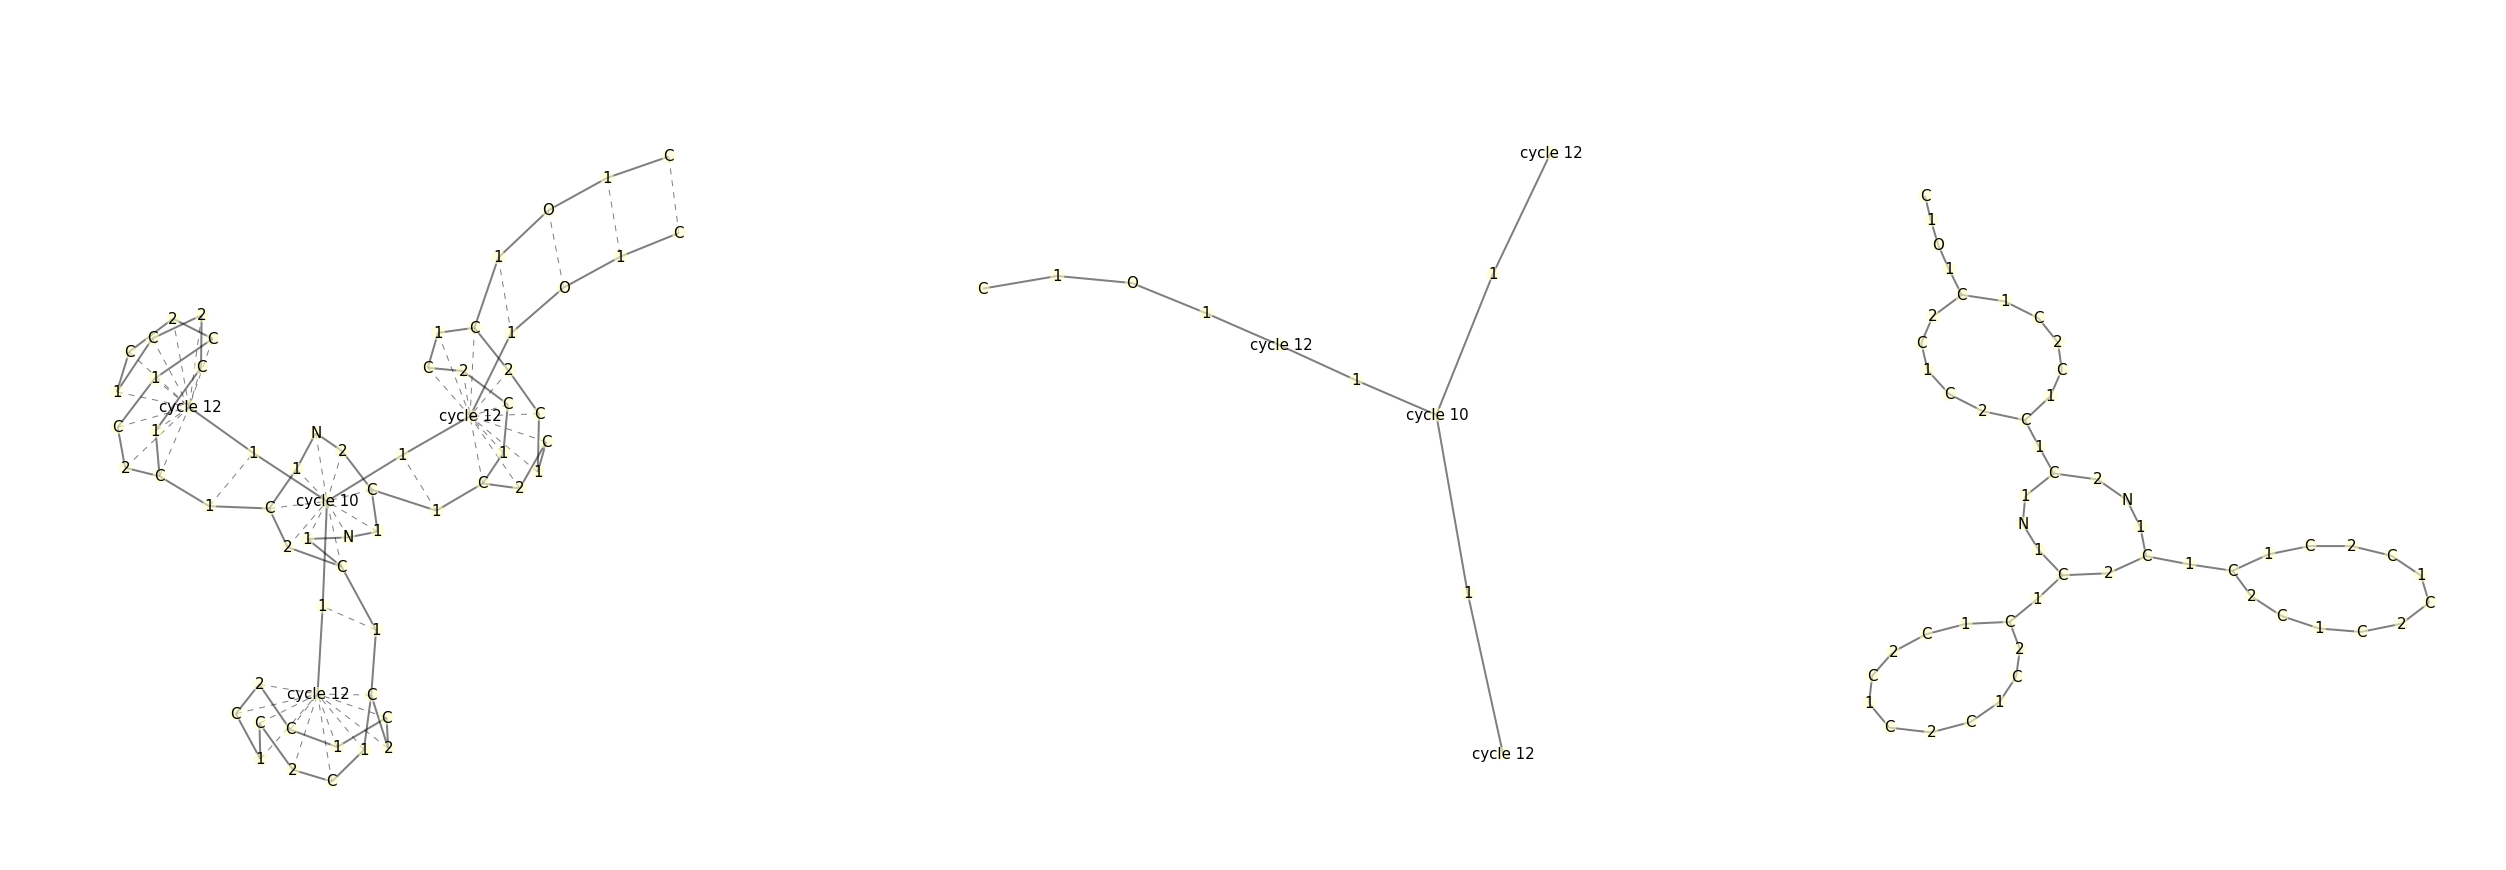

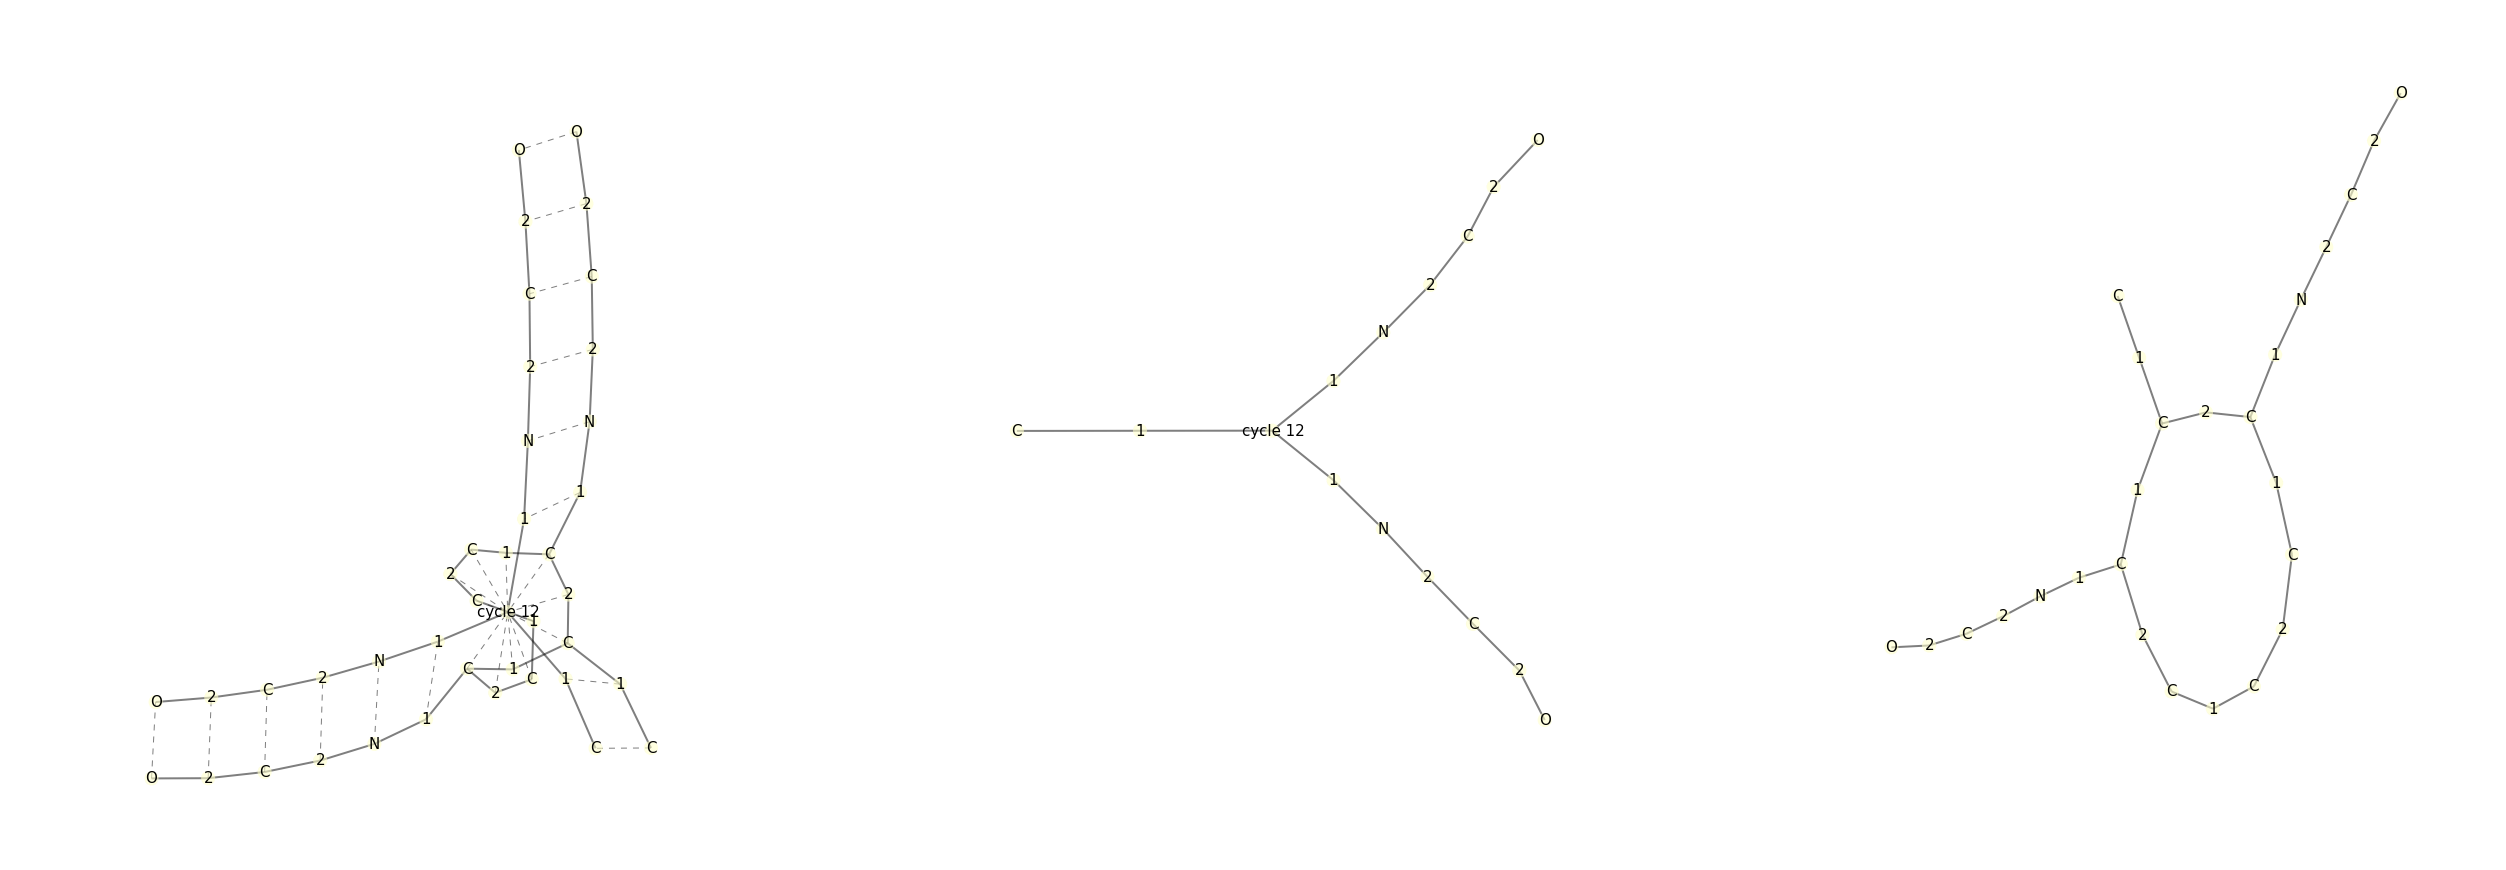

DEMONSTRATING EXTRACTION


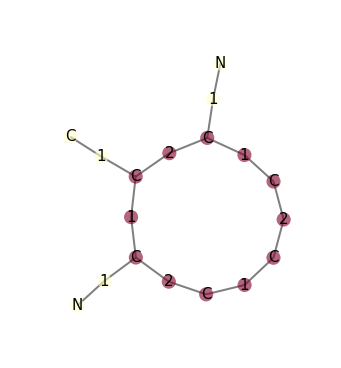

In [17]:
'''TESTING EXTRACTION AND GRAPHMANAGER'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.molecules as mole
from eden.graph import Vectorizer

import graphlearn.abstract_graphs.ubergraphlearn as ugly
vectorizer=Vectorizer()

print 'DEMONSTRATING GRAPH MANAGER'
graphs=get_graphs()

for i in range(2):
    g=graphs.next()
    gm=mole.MolecularGraphManager(g,vectorizer,base_thickness_list=[2])
    draw.graphlearn([gm.graph(nested=True),gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = 'label',contract=False)

print 'DEMONSTRATING EXTRACTION'  
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
argz=(gm,radius_list,thickness_list,Vectorizer(),2**20-1,lambda x,y:True, base_thickness_list)

cips=gm.all_cips(thickness_list=[2],radius_list=[0,1],hash_bitmask=2**20-1)
draw.graphlearn(cips[0][0].graph, contract=False)

In [18]:
%%time
'''
learning a grammar
'''
import graphlearn.abstract_graphs.molecules as mole
graphs = get_graphs()
sampler=mole.MolecularSampler(radius_list=[0,1],thickness_list=[1], min_cip_count=1, min_interface_count=2)
sampler.fit(graphs,n_jobs=1,batch_size=1)
sampler.save('tmp/mole_ubergrammar.ge')

CPU times: user 31.1 s, sys: 2.89 s, total: 34 s
Wall time: 31.2 s


interface id: 427728 [36 options]


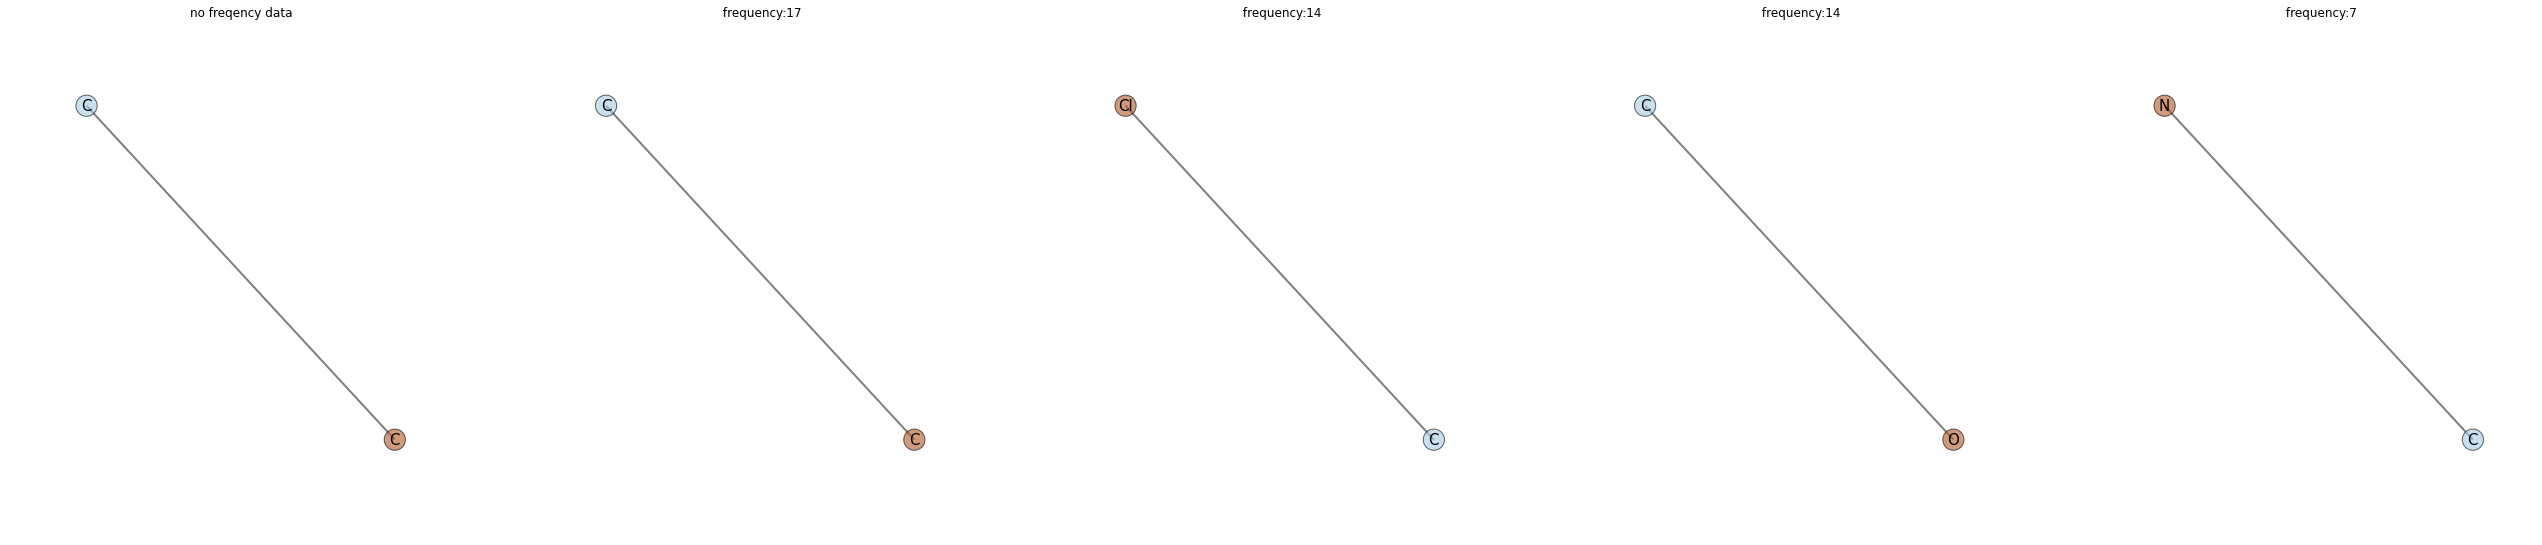

interface id: 82896 [28 options]


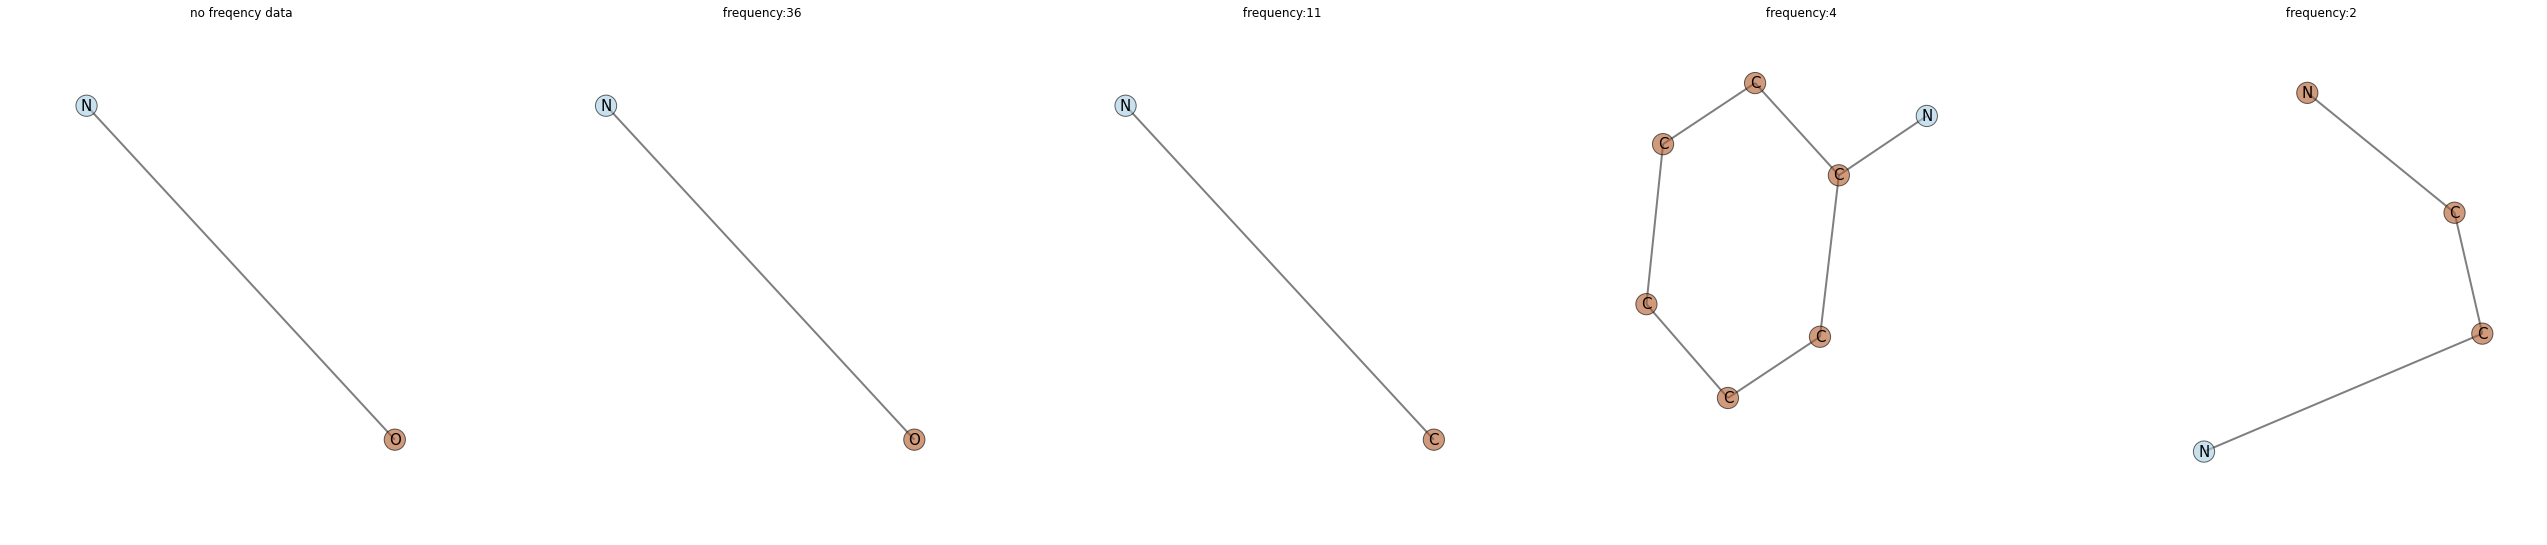

interface id: 109808 [27 options]


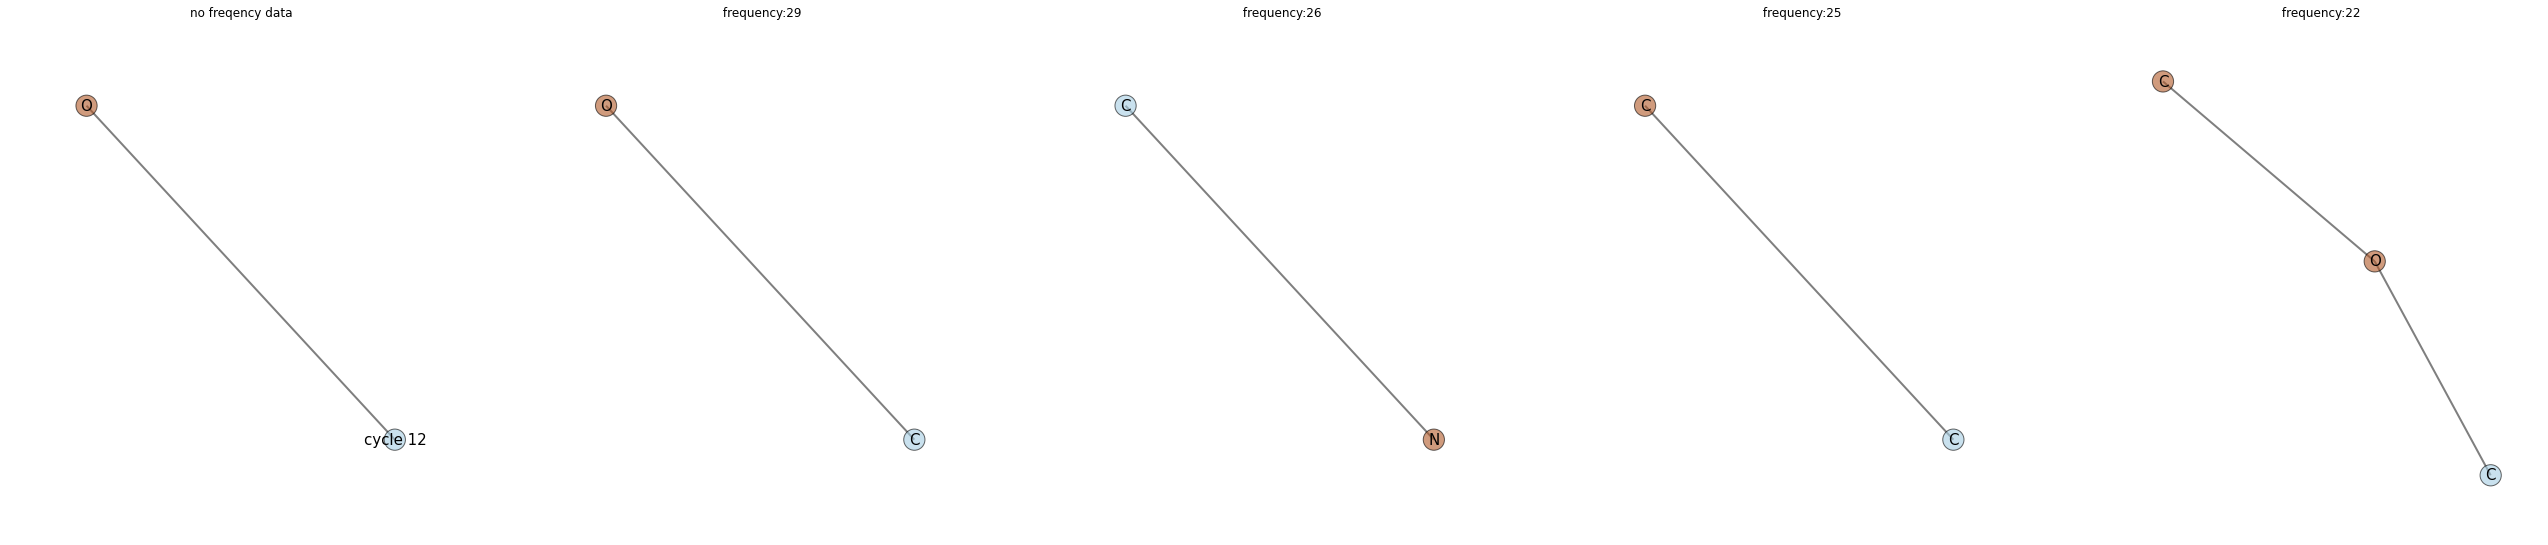

interface id: 236395 [26 options]


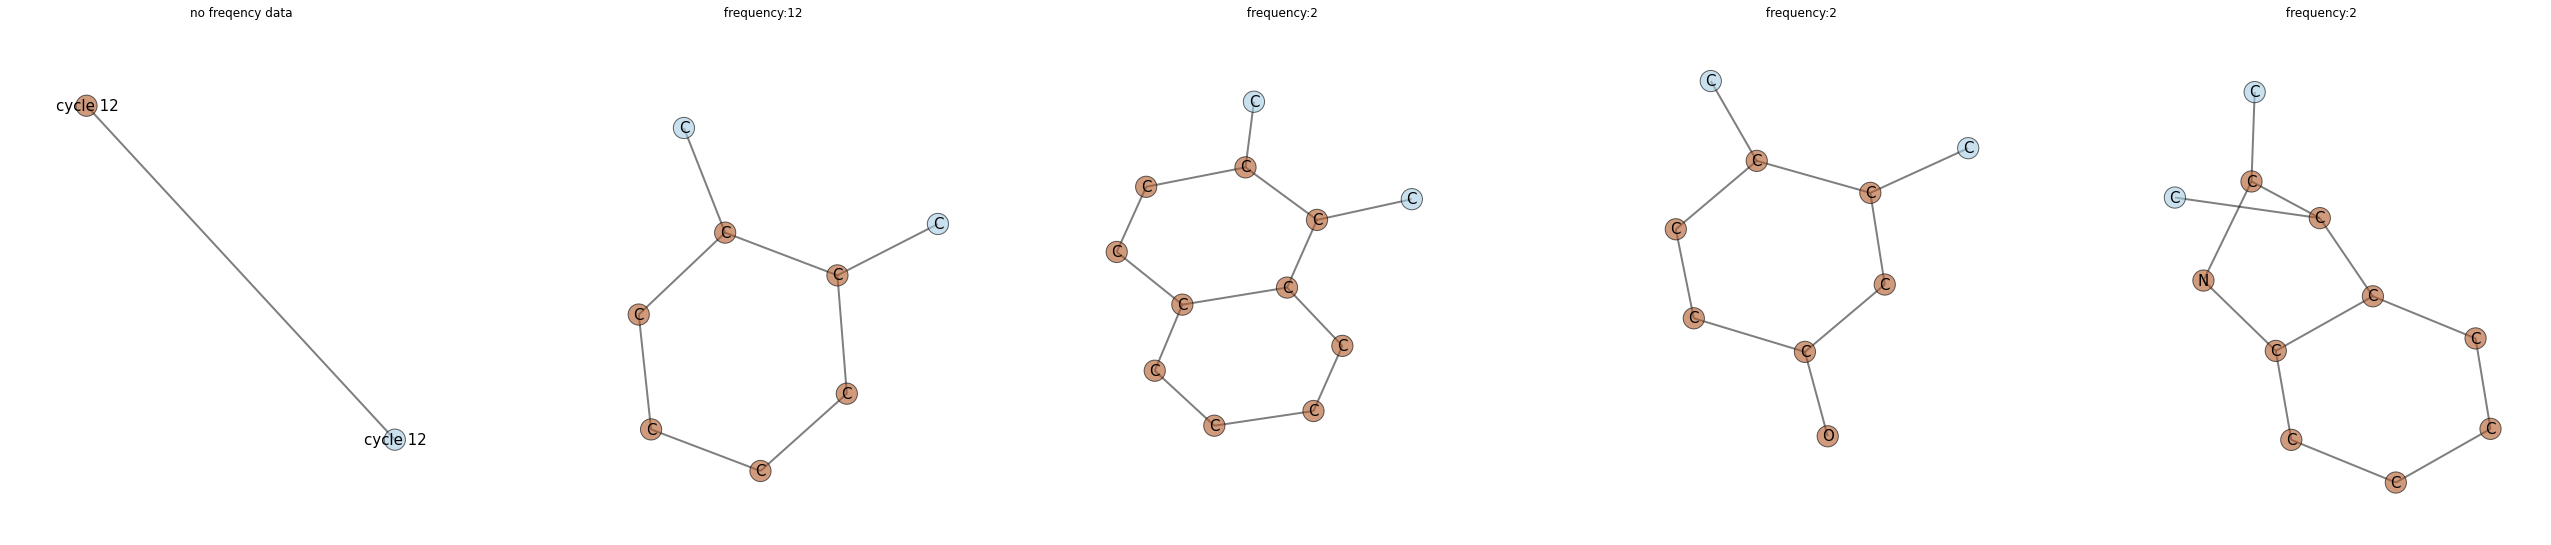

interface id: 873314 [19 options]


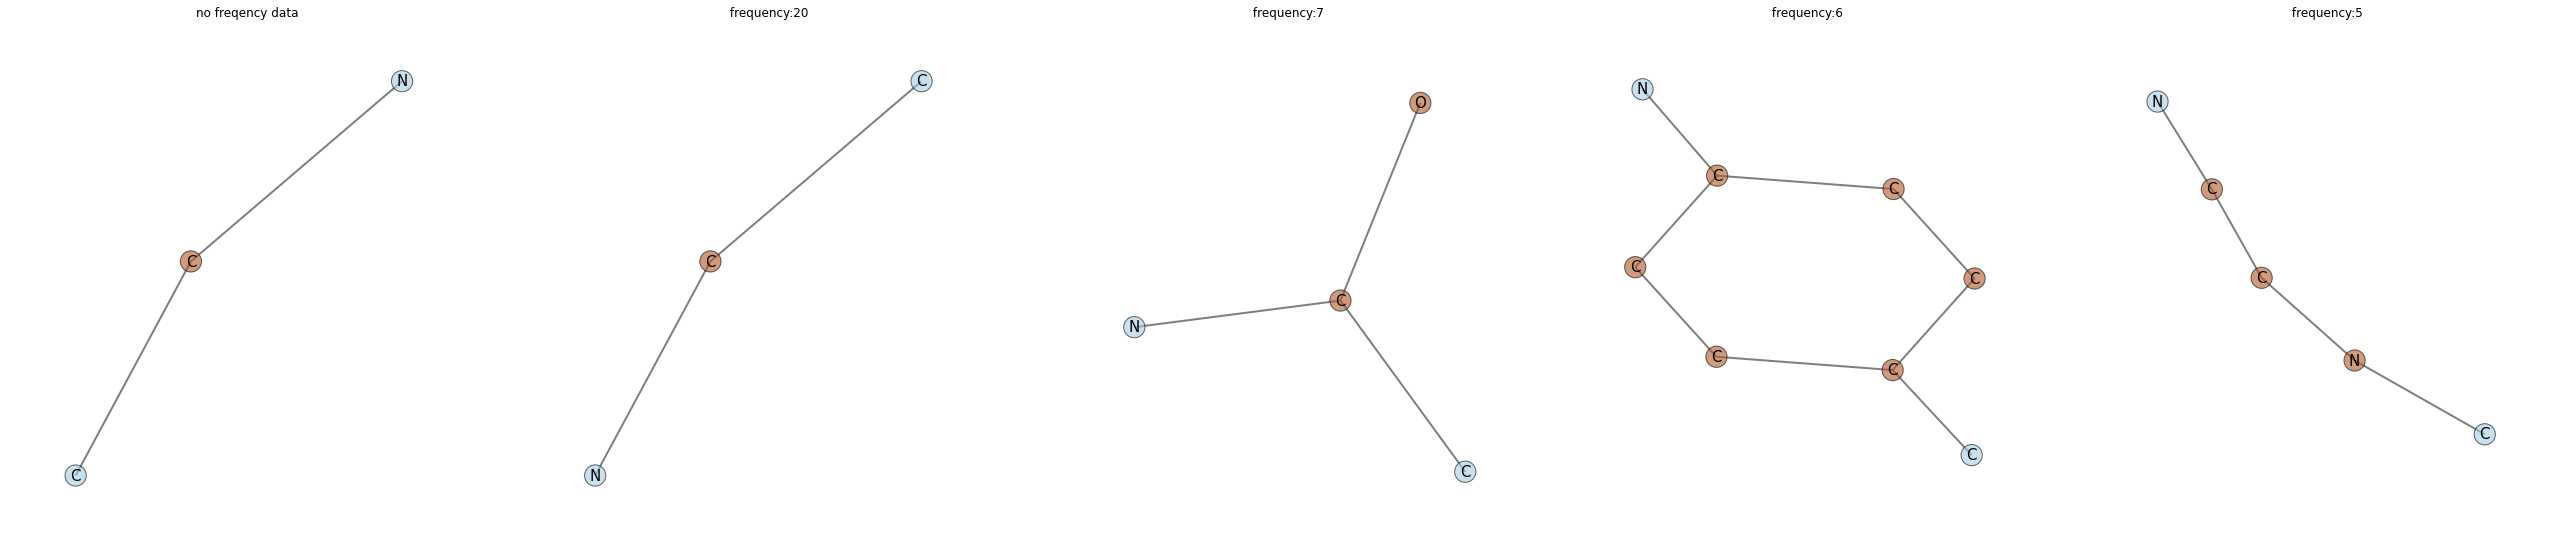

In [19]:
#draw production rules
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=True,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)

    

Graph id: 15


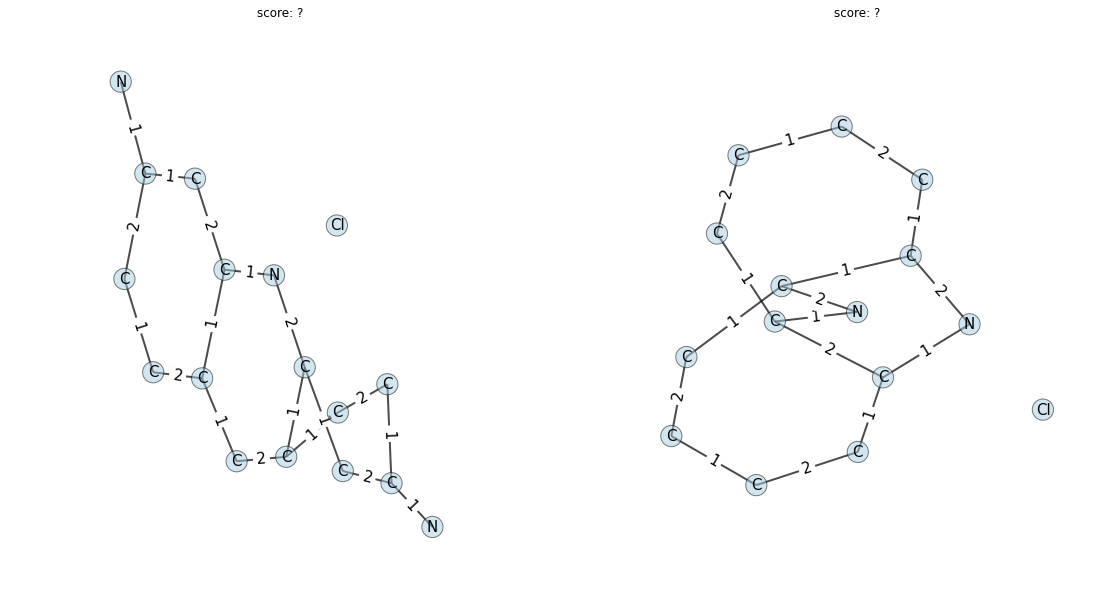

Graph id: 16


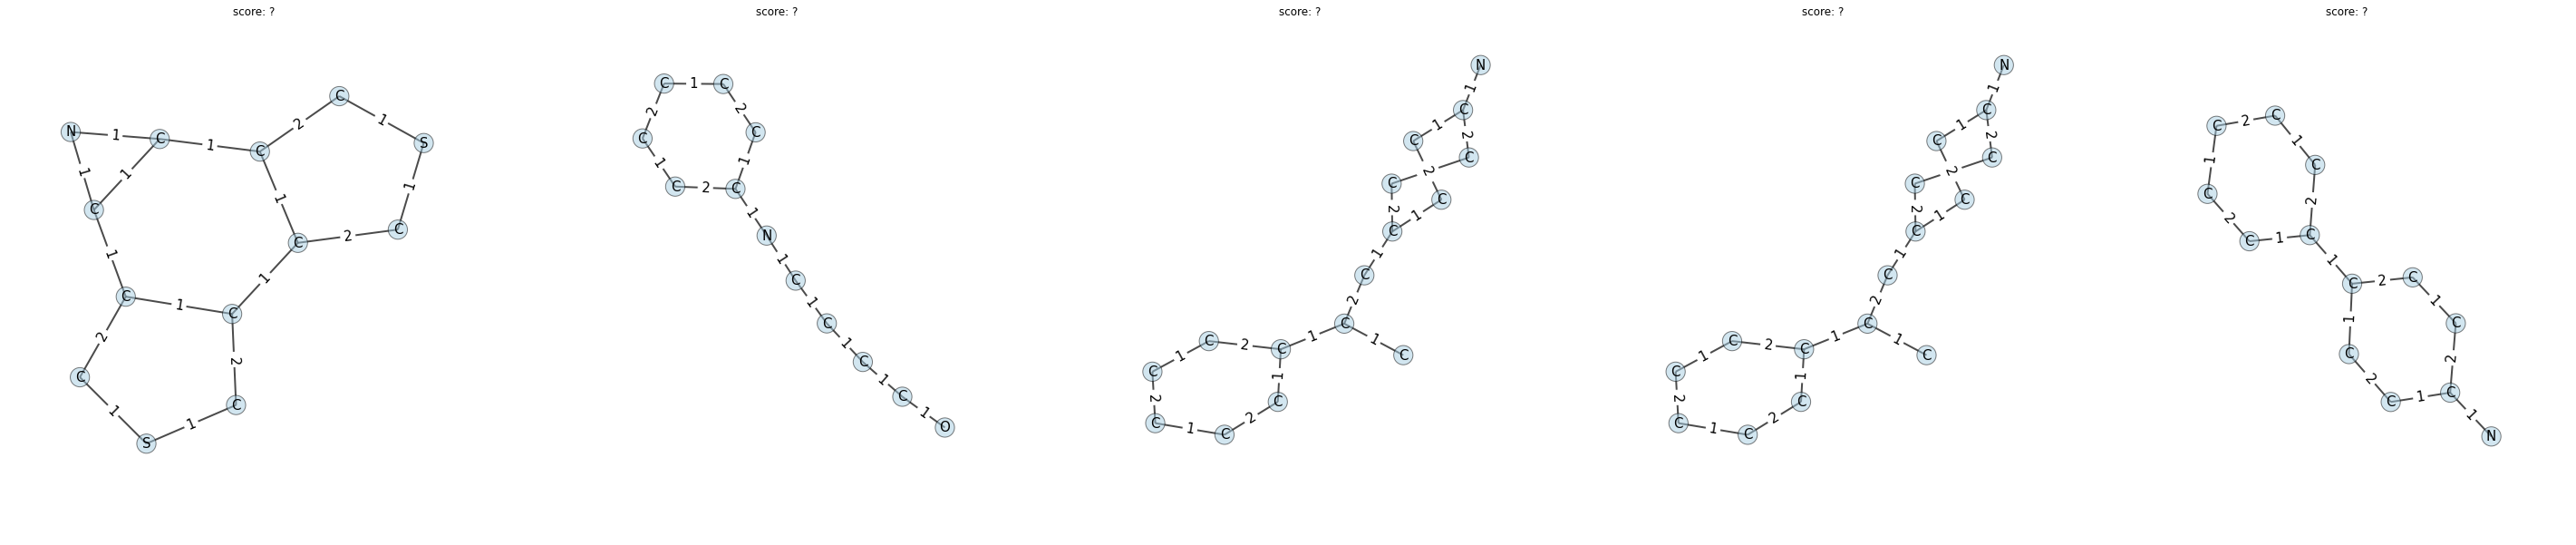

Graph id: 17


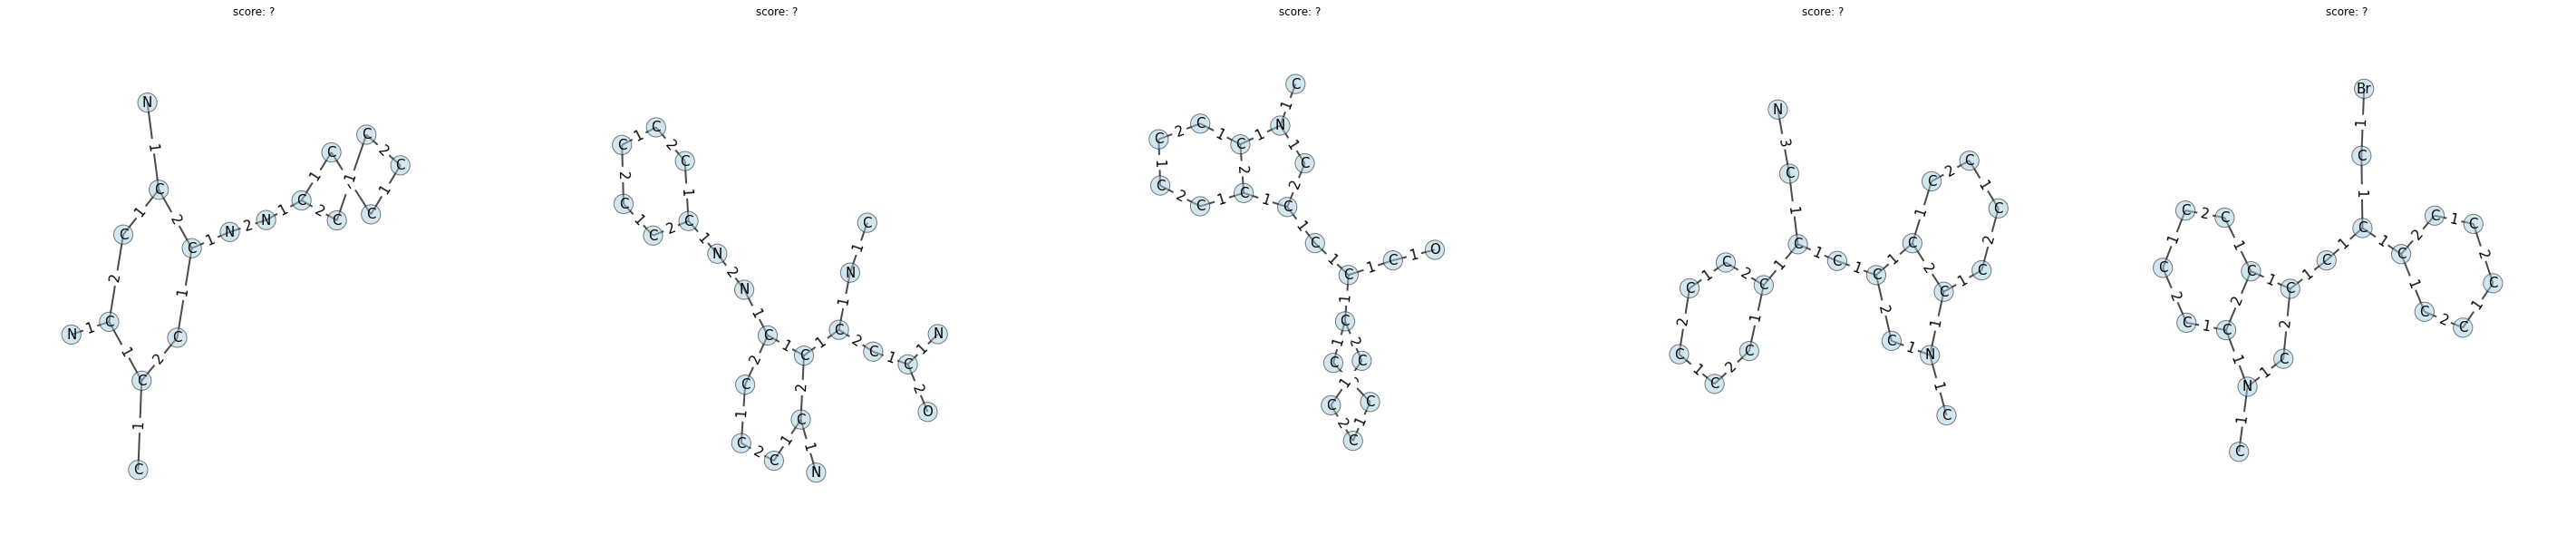

Graph id: 18


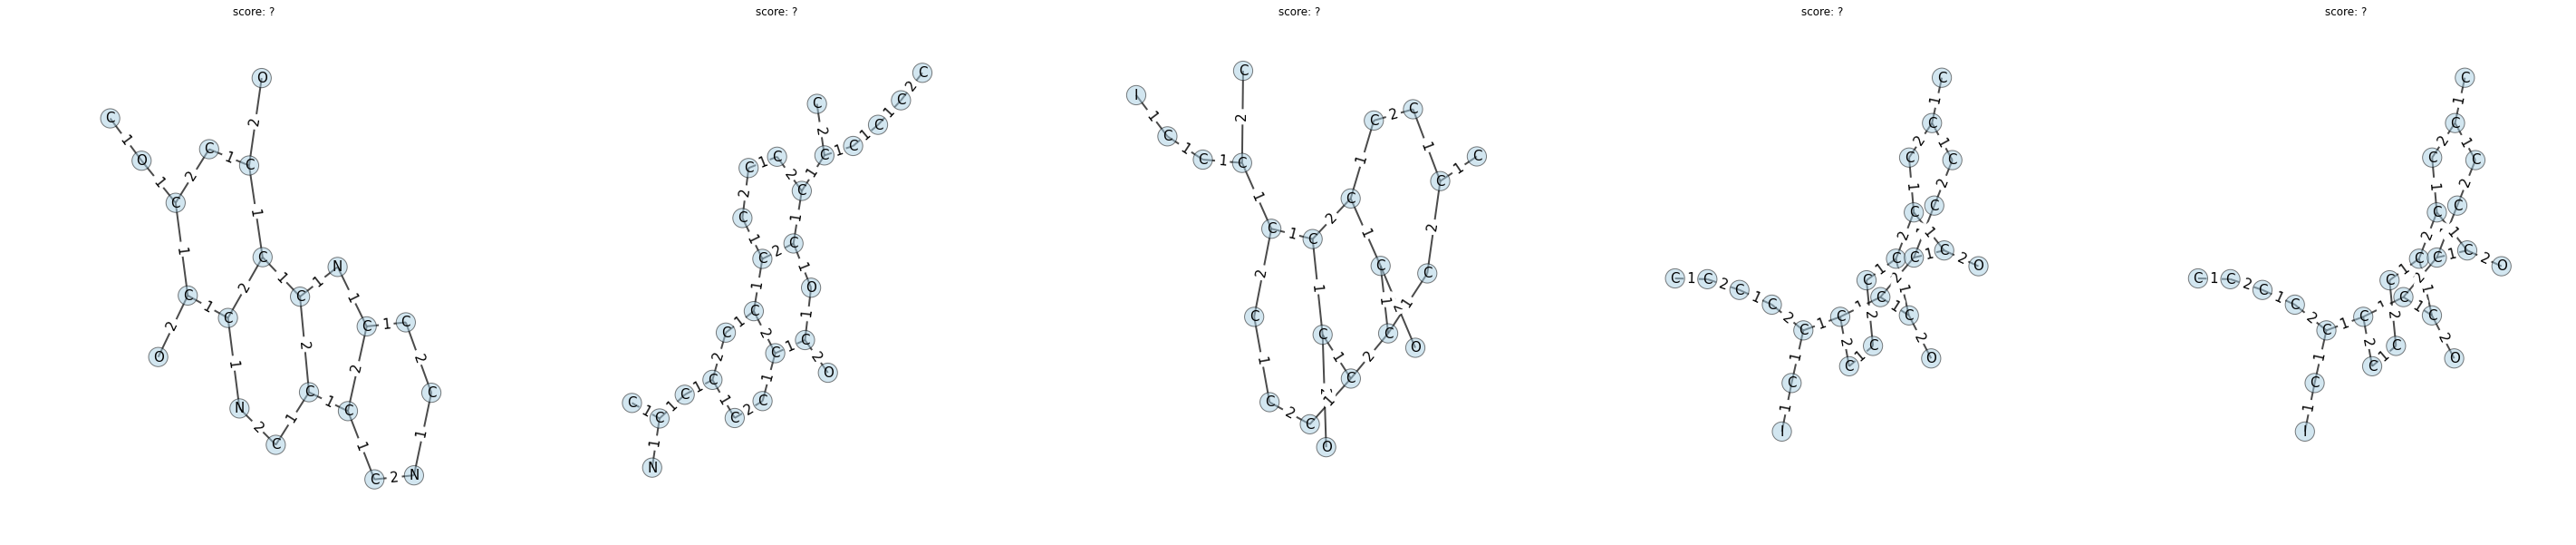

Graph id: 19


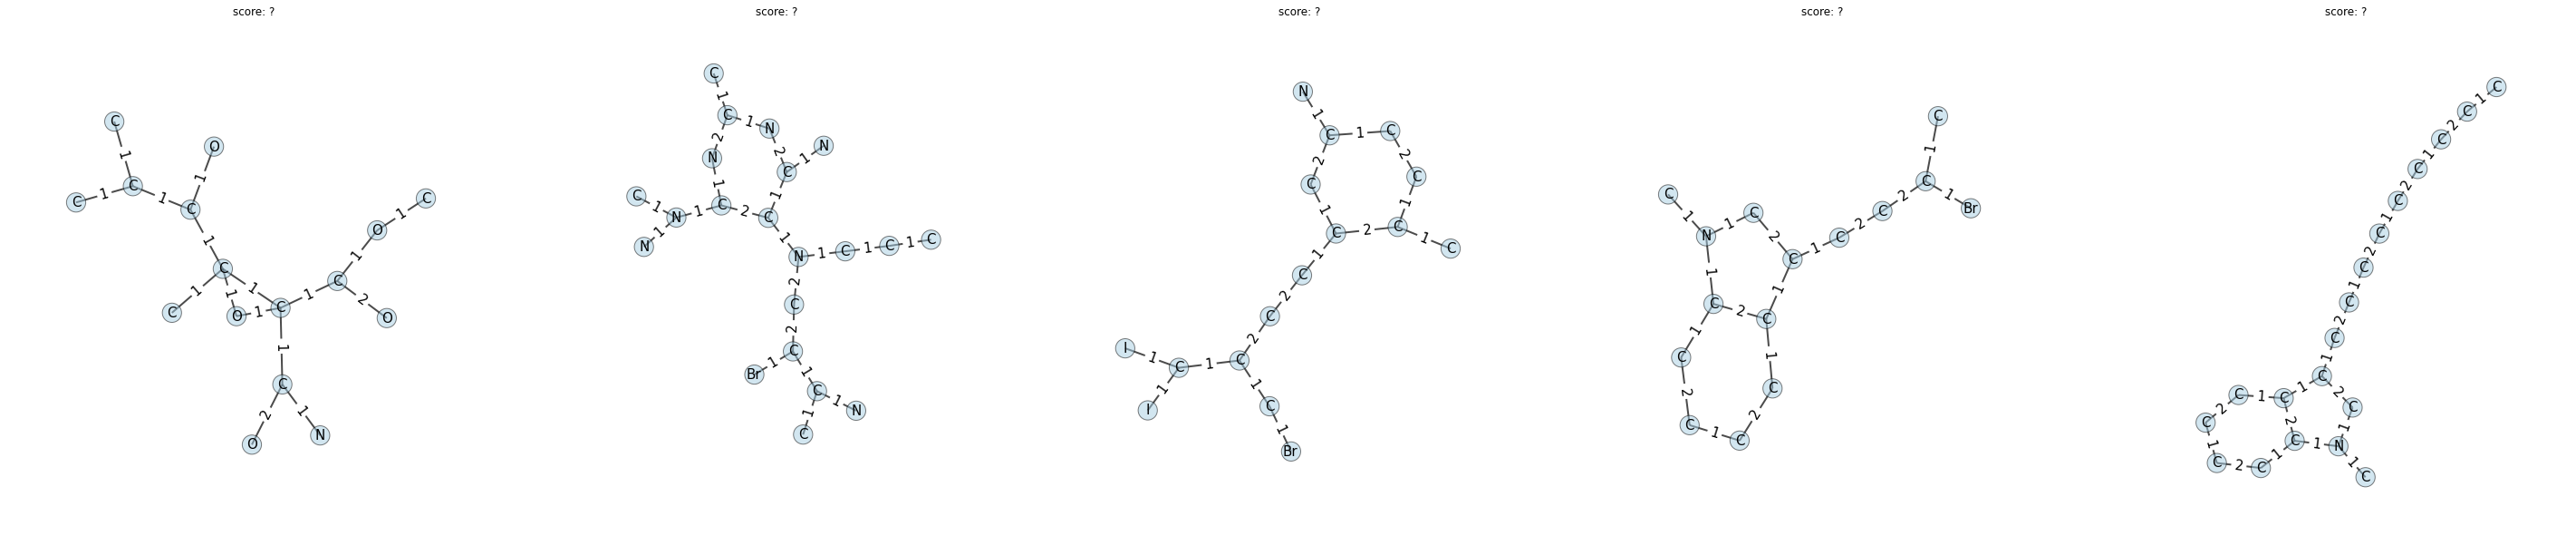

Graph id: 20


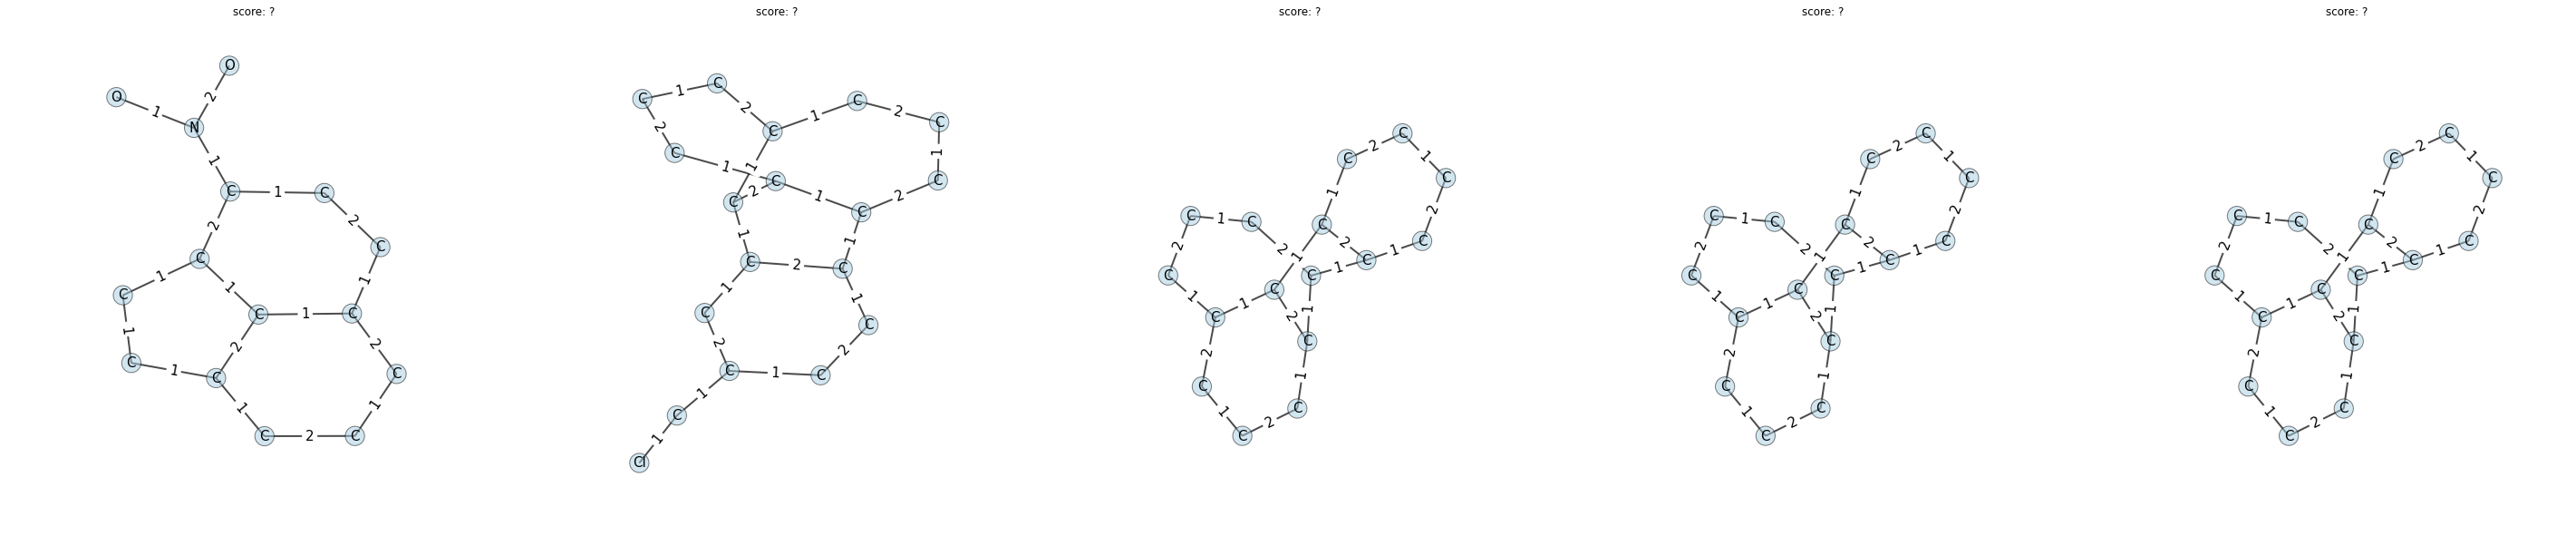

Graph id: 21


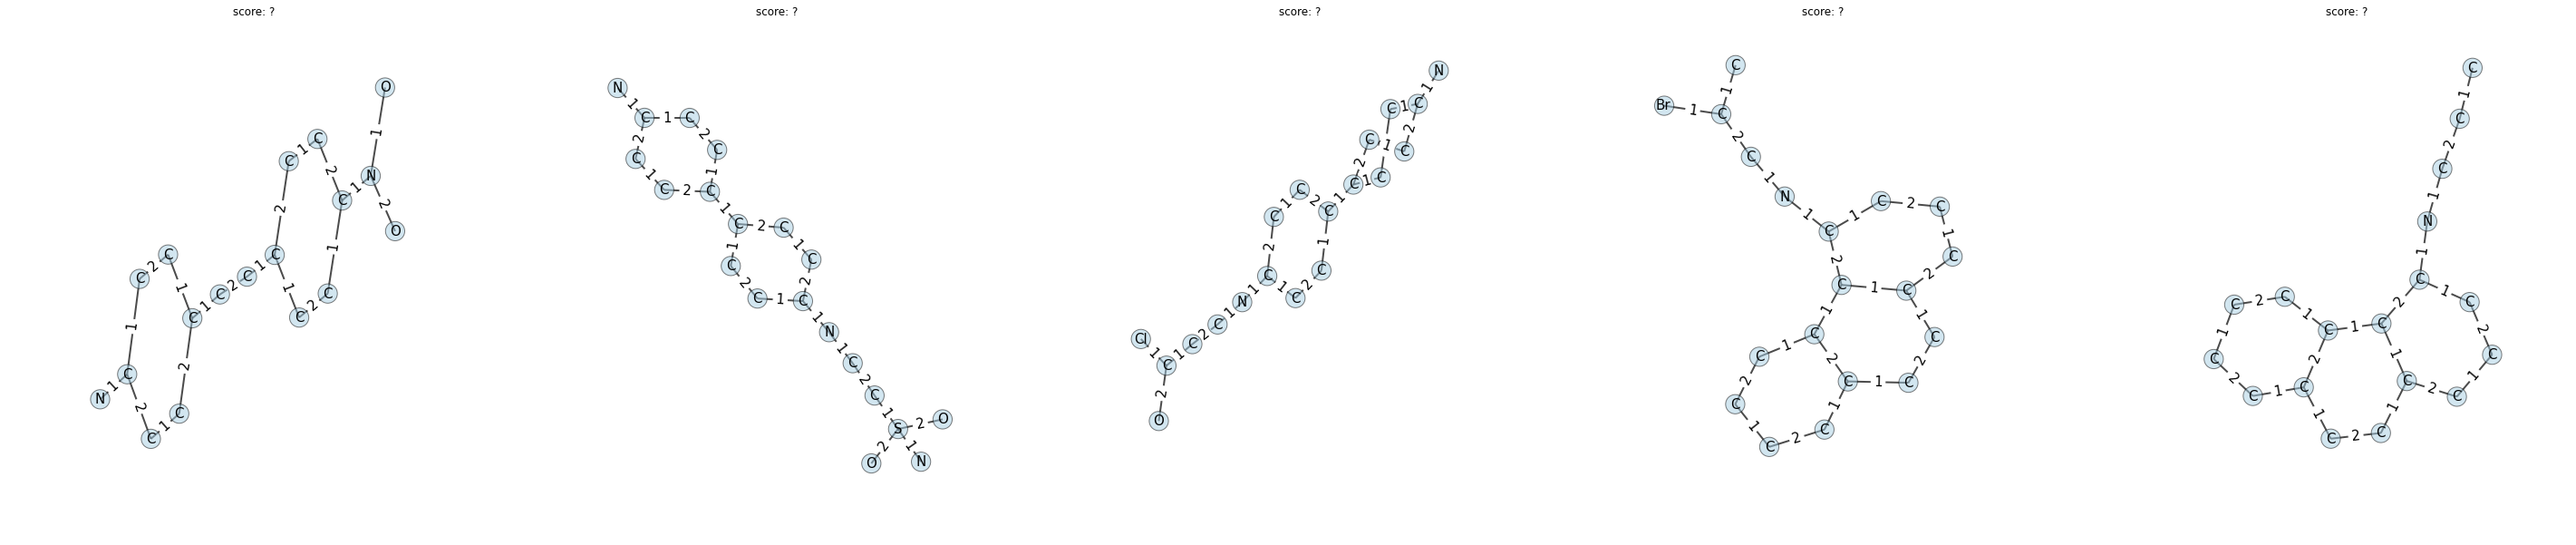

Graph id: 22


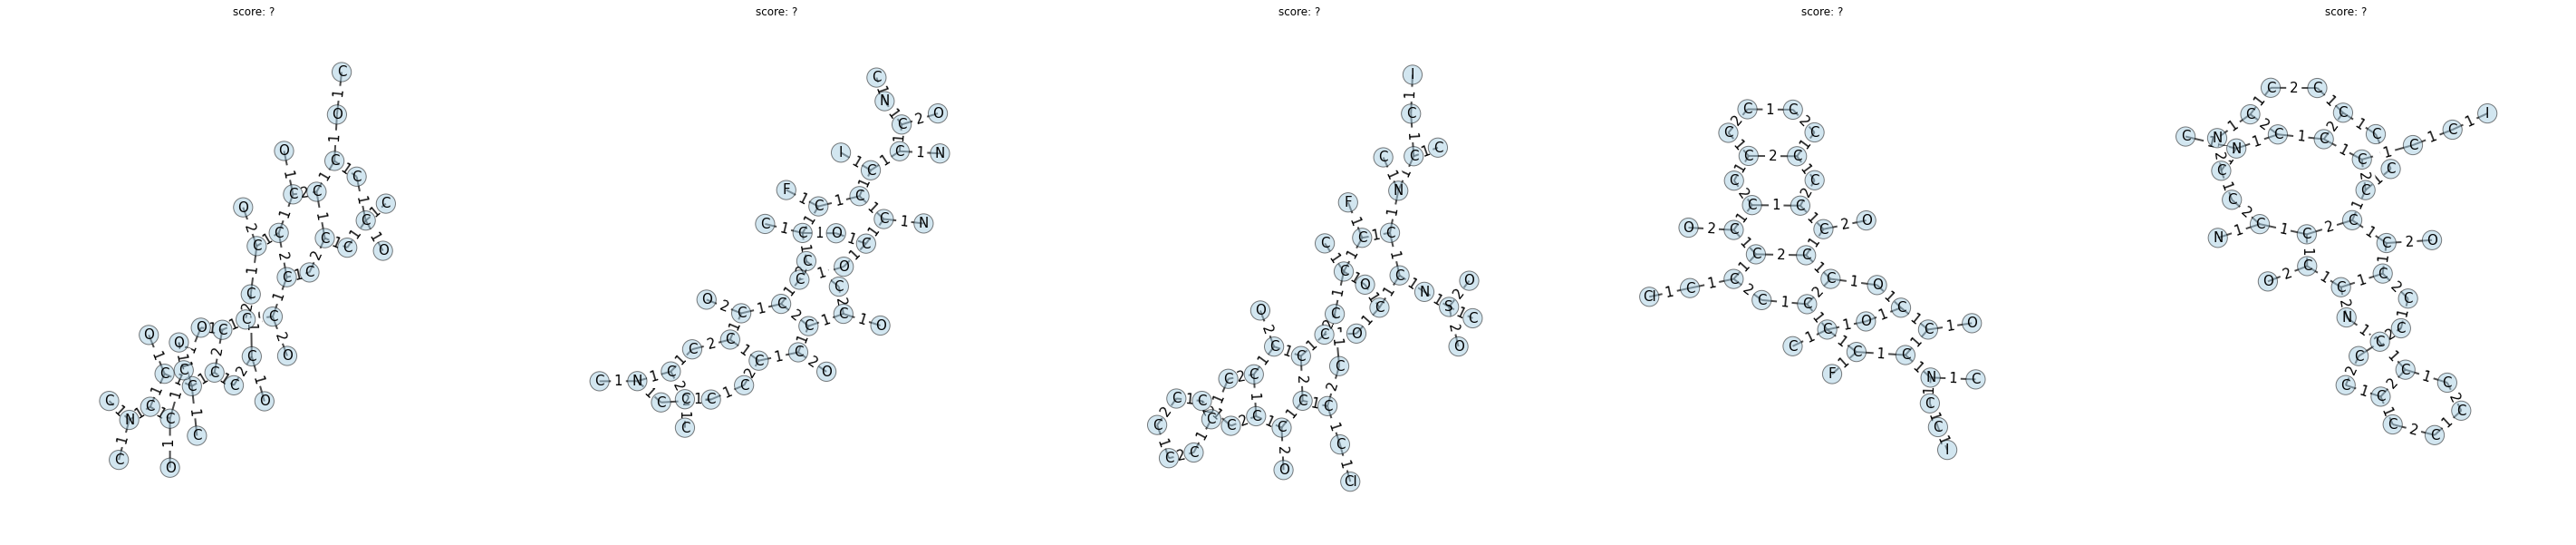

Graph id: 23


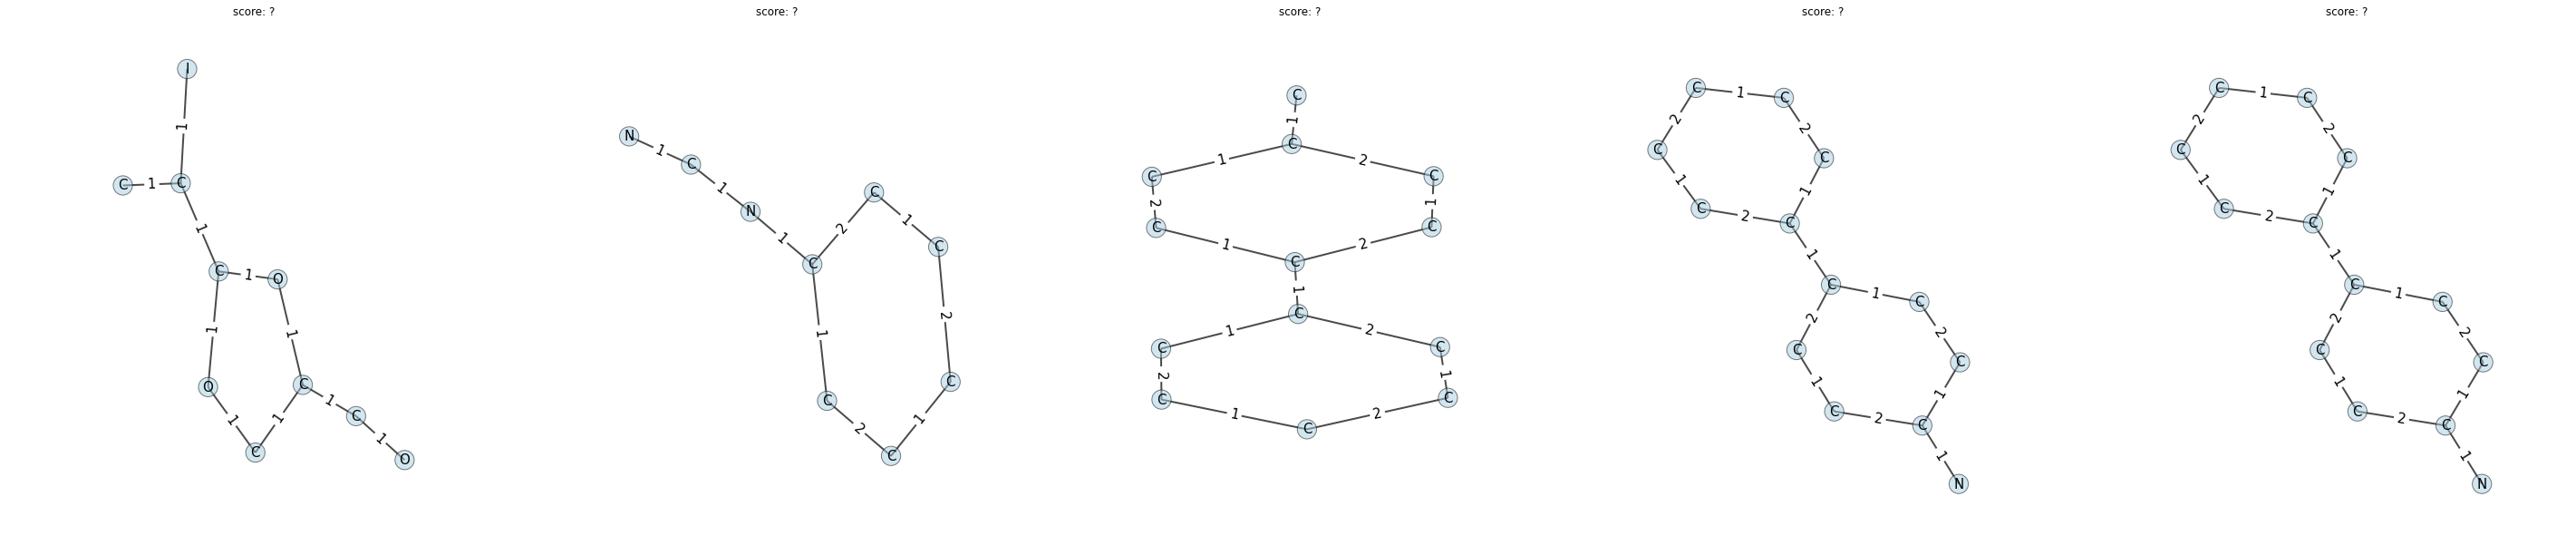

CPU times: user 19 s, sys: 2.5 s, total: 21.5 s
Wall time: 44.7 s


In [20]:
%%time
'''
RNA sampling
'''
import os
os.nice(19)
import graphlearn.utils.draw as draw
import graphlearn.abstract_graphs.molecules as mole
import itertools
#sampler=mole.MolecularSampler()
#sampler.load('tmp/mole_ubergrammar.ge')
graphs = get_graphs()

id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=100

graphs = sampler.sample(graphs,
                        n_samples=5,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=4,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=False,
                        burnin=0,
                        improving_threshold=0.5,
                        max_core_size_diff=5,
                        select_cip_max_tries=100,
                        keep_duplicates=True,
                        omit_seed=False)

 
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    

    path_graphs= list(path_graphs)
    draw.graphlearn(path_graphs,
                           n_graphs_per_line=5, size=10, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label',
                          headlinehook= draw.get_score_of_graph
                          )
    

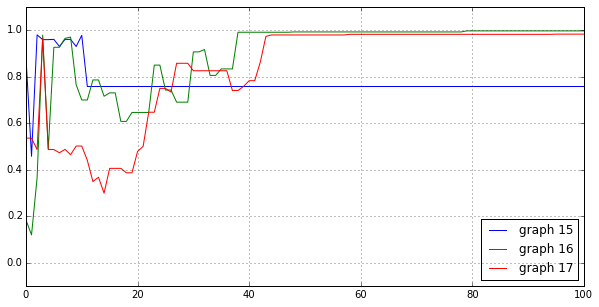

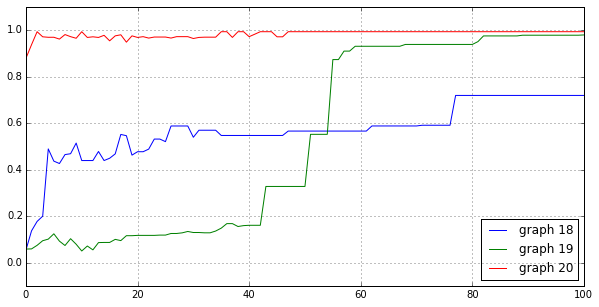

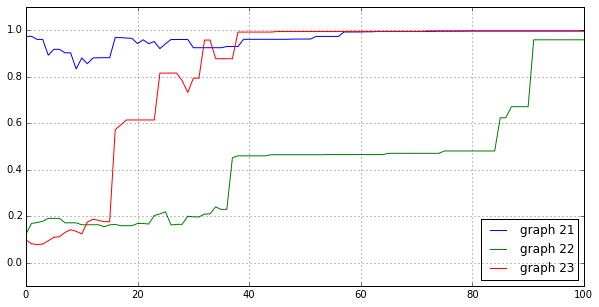

In [21]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

In [22]:

import networkx as nx
import graphlearn.utils.draw as draw
from eden.graph import Vectorizer

v=Vectorizer()
def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

g=getpathgraph("ABC")

g= v._edge_to_vertex_transform(g)

draw.graphlearn_draw(g,contract=False,show_direction=True)

g2=nx.DiGraph(g)
#draw.display(g2,contract=False,vertex_label='id')

for n,d in g2.nodes(data=True):
    if 'edge' in d:
        if d['label']=='.':
            ns=g2.neighbors(n)
            g2.remove_edge(ns[1],n)
            g2.remove_edge(n,ns[0])
          
       
#g2 = g2.to_undirected()
draw.graphlearn_draw(g2,contract=False,vertex_label='id',show_direction=True)
g2.edges()
for n in g2.nodes():
    print n,g2.neighbors(n)
print isinstance(g2, nx.DiGraph) 

AttributeError: 'module' object has no attribute 'graphlearn_draw'

In [ ]:
g2.edges(0,data=True)

In [ ]:
asd = g2.subgraph(range(2)).copy()

In [ ]:
class A(object):
    def __init__(self,a=123):
        self.a=a
        
        
class B(A):
    def __init__(self,b=122):
        super(B,self).__init__(b)
        
        

class C(A):
    def __init__(self,c=121):
        super(C,self).__init__(c)
        
        
c=C()
c.a
        
        
        
    
    

In [ ]:
# testin cycle stuff
import networkx as nx
import graphlearn.utils.draw as draw
import graphlearn.feasibility as feas
from eden.graph import Vectorizer
v=Vectorizer()
%matplotlib inline


def find_all_cycles(G, source=None, cycle_length_limit=None):
    """forked from networkx dfs_edges function. Assumes nodes are integers, or at least
    types which work with min() and > ."""
    if source is None:
        # produce edges for all components
        nodes=[i[0] for i in nx.connected_components(G)]
    else:
        # produce edges for components with source
        nodes=[source]
    # extra variables for cycle detection:
    cycle_stack = []
    output_cycles = set()
    
    def get_hashable_cycle(cycle):
        """cycle as a tuple in a deterministic order."""
        m = min(cycle)
        mi = cycle.index(m)
        mi_plus_1 = mi + 1 if mi < len(cycle) - 1 else 0
        if cycle[mi-1] > cycle[mi_plus_1]:
            result = cycle[mi:] + cycle[:mi]
        else:
            result = list(reversed(cycle[:mi_plus_1])) + list(reversed(cycle[mi_plus_1:]))
        return tuple(result)
    
    for start in nodes:
        if start in cycle_stack:
            continue
        cycle_stack.append(start)
        
        stack = [(start,iter(G[start]))]
        while stack:
            parent,children = stack[-1]
            try:
                child = next(children)
                
                if child not in cycle_stack:
                    cycle_stack.append(child)
                    stack.append((child,iter(G[child])))
                else:
                    i = cycle_stack.index(child)
                    if i < len(cycle_stack) - 2: 
                      output_cycles.add(get_hashable_cycle(cycle_stack[i:]))
                
            except StopIteration:
                stack.pop()
                cycle_stack.pop()
    
    return [list(i) for i in output_cycles]


def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

#g=getpathgraph("ABC")

#g= v._edge_to_vertex_transform(g)

#draw.graphlearn_draw(g,contract=False,show_direction=True)


#draw.display(g2,contract=False,vertex_label='id')

g=nx.cycle_graph(10)
g.add_edge(2,7)
g.add_edge(10,0)

draw.graphlearn_draw(g, vertex_label='id')


feas.rooted_problem_cycle(g,2,4)

In [ ]:
print g.graph